In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns

# Importing canard_explosions functions
import sys
sys.path.append('..')
from canard_explosions.FH_N import FH_N

In [6]:
t_span = [0, 200]
y0 = [-0.5, -3.0]

soln = solve_ivp(FH_N, t_span, y0)

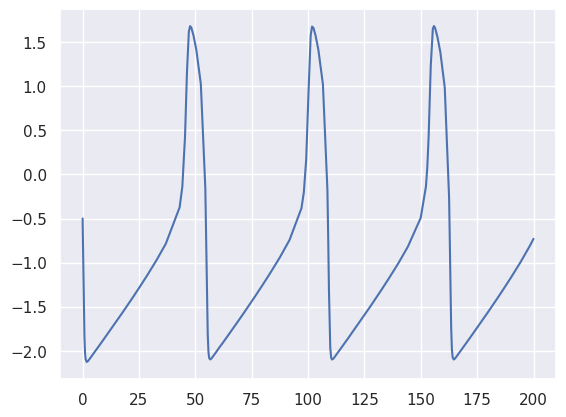

In [7]:
sns.set_theme(style="darkgrid")
plt.plot(soln.t, soln.y[0])
plt.show()